In [2]:
from datasets import load_dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch

# Load the dataset from Hugging Face
dataset = load_dataset("AlFrauch/im2latex")
train_data = dataset['train']

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

data-00000-of-00009.arrow:   0%|          | 0.00/547M [00:00<?, ?B/s]

data-00001-of-00009.arrow:   0%|          | 0.00/552M [00:00<?, ?B/s]

data-00002-of-00009.arrow:   0%|          | 0.00/561M [00:00<?, ?B/s]

data-00003-of-00009.arrow:   0%|          | 0.00/551M [00:00<?, ?B/s]

data-00004-of-00009.arrow:   0%|          | 0.00/546M [00:00<?, ?B/s]

data-00005-of-00009.arrow:   0%|          | 0.00/542M [00:00<?, ?B/s]

data-00006-of-00009.arrow:   0%|          | 0.00/542M [00:00<?, ?B/s]

data-00007-of-00009.arrow:   0%|          | 0.00/560M [00:00<?, ?B/s]

data-00008-of-00009.arrow:   0%|          | 0.00/544M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1586584 [00:00<?, ? examples/s]

In [3]:
data_fraction = 0.015
shuffled_data = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * data_fraction)))
split_index = int(0.8 * len(shuffled_data))
train_data = shuffled_data.select(range(split_index))
eval_data = shuffled_data.select(range(split_index, len(shuffled_data)))

In [4]:
# Load the processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: [

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
# Freeze encoder layers if needed (optional for efficiency)
for param in model.encoder.parameters():
    param.requires_grad = False

In [6]:
# Preprocessing function
from PIL import Image


def preprocess_data(batch):
    # Assume each image in the batch is already a PIL image object; convert to RGB if needed
    images = [image.convert("RGB") if image.mode != "RGB" else image for image in batch["image"]]
    
    # Process images and labels
    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    labels = processor.tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128).input_ids
    labels = [[(label if label != processor.tokenizer.pad_token_id else -100) for label in label_ids] for label_ids in labels]
    
    return {"pixel_values": pixel_values, "labels": labels}


    
    return {
        "pixel_values": pixel_values,
        "labels": torch.tensor(labels),
        "decoder_input_ids": model.prepare_decoder_input_ids_from_labels(torch.tensor(labels))
    }

In [7]:
# Map the preprocessing over the training data
train_data = train_data.map(preprocess_data, batched=True)

Map:   0%|          | 0/19038 [00:00<?, ? examples/s]

In [12]:
# Set up training arguments
# Set up training arguments with `remove_unused_columns=False`
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working",
    per_device_train_batch_size=12,
    gradient_accumulation_steps=4,
    evaluation_strategy="no",  # Disable evaluation to prevent issues
    learning_rate=2e-5,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    save_steps=500,
    save_total_limit=2,
    logging_dir='/kaggle/working/logs',
    #remove_unused_columns=False,  # Keep all columns for model processing
)


# Define Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    #eval_dataset=eval_data,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Line

In [15]:
# Fine-tune the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


TrainOutput(global_step=396, training_loss=1.924712518248895, metrics={'train_runtime': 21169.6038, 'train_samples_per_second': 1.799, 'train_steps_per_second': 0.019, 'total_flos': 5.10554944422795e+19, 'train_loss': 1.924712518248895, 'epoch': 1.994962216624685})

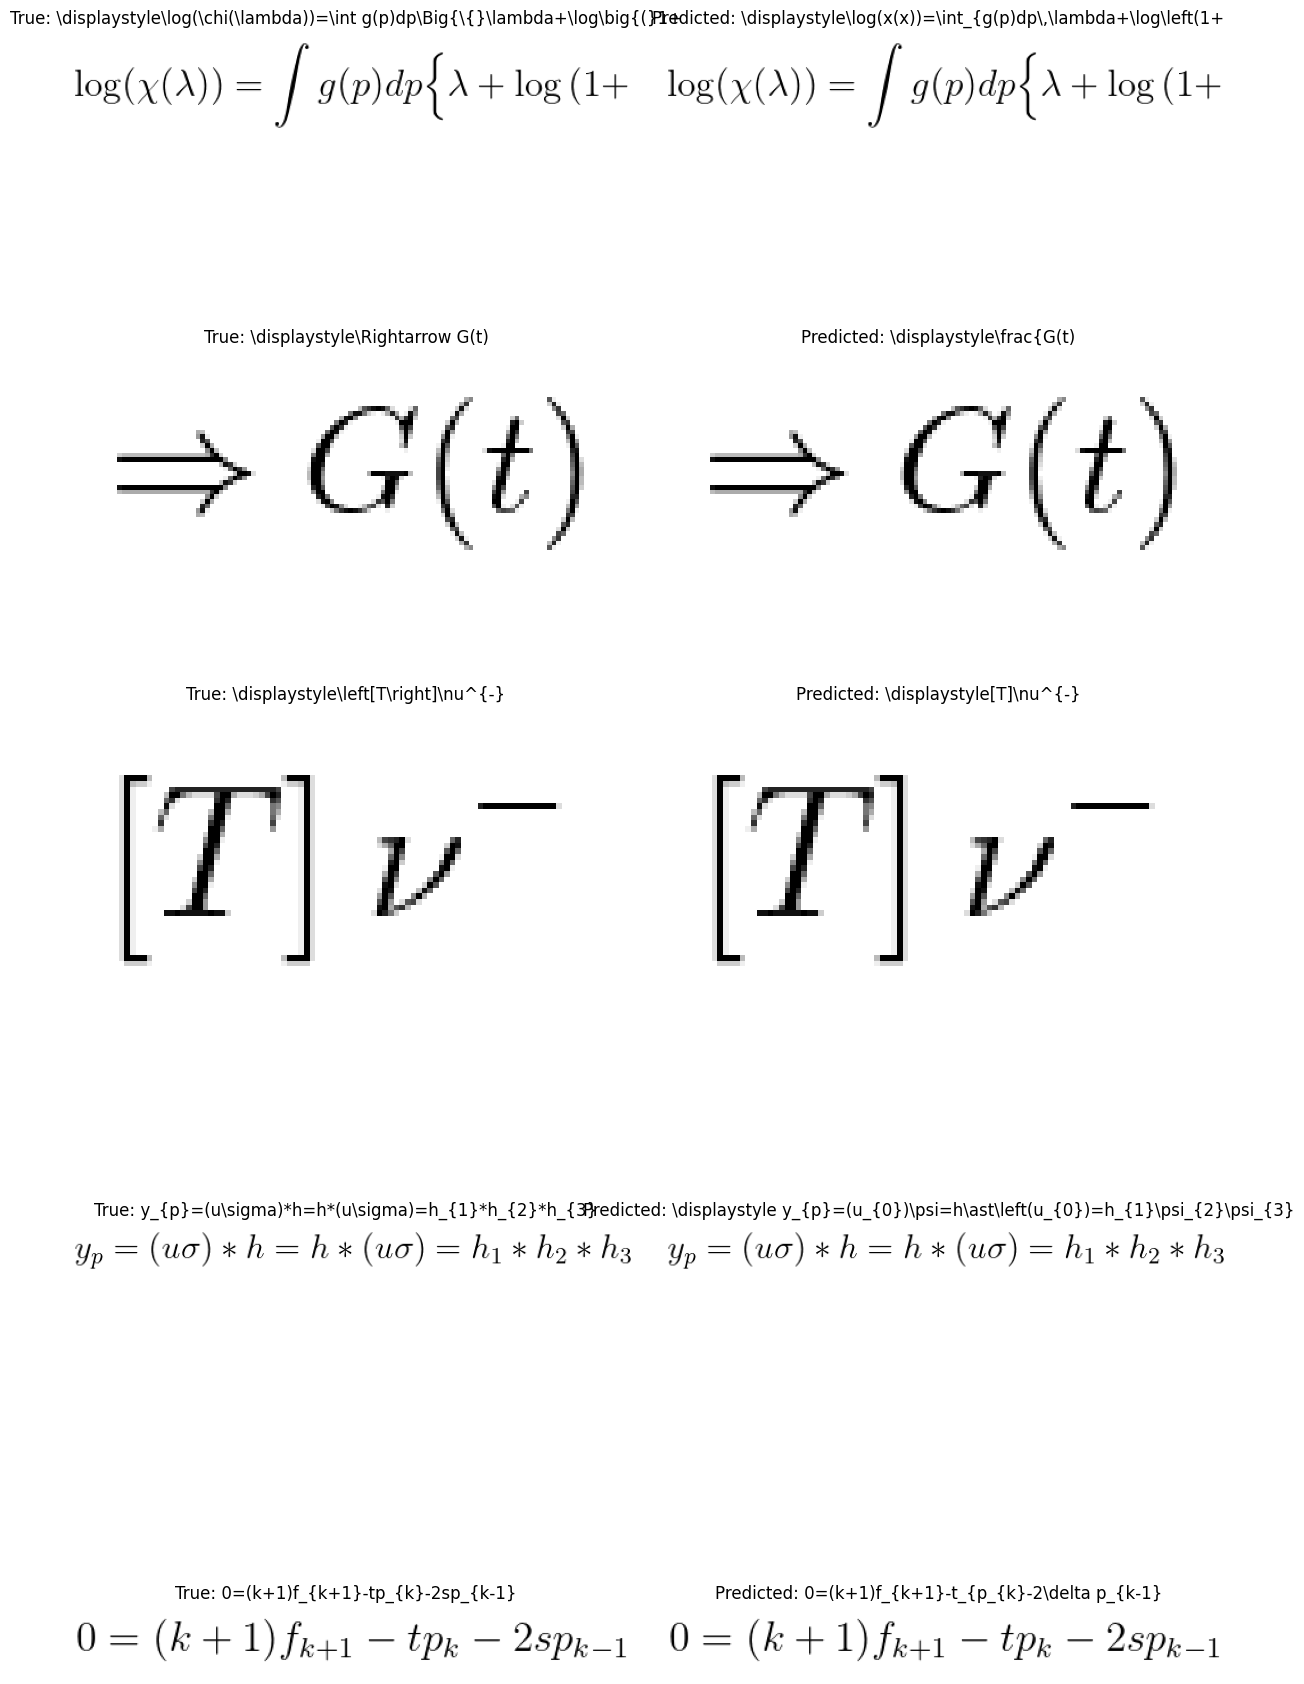

In [16]:
import matplotlib.pyplot as plt

# Function to perform inference and visualize predictions vs true labels
def visualize_predictions(dataset, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(12, num_samples * 4))
    
    # Select a random subset of samples
    subset = dataset.shuffle(seed=42).select(range(num_samples))
    
    for idx, sample in enumerate(subset):
        # Preprocess the image for the model
        image = sample["image"].convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
        
        # Generate prediction
        with torch.no_grad():
            output_ids = model.generate(pixel_values, max_length=128)
        
        # Decode predicted and true labels
        predicted_text = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        true_text = sample["text"]

        # Display the image, true label, and predicted label
        axs[idx, 0].imshow(image)
        axs[idx, 0].axis("off")
        axs[idx, 0].set_title(f"True: {true_text}")
        
        axs[idx, 1].imshow(image)
        axs[idx, 1].axis("off")
        axs[idx, 1].set_title(f"Predicted: {predicted_text}")
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_predictions(train_data)


In [17]:
# # Fine-tune the model
# #trainer.train()

# # Define the path where you want to save the model
# save_path = "/kaggle/working/fine_tuned_trocr_model.pth"

# # Save the model's state_dict (weights) to the specified path
# torch.save(model.state_dict(), save_path)

# print(f"Model saved to {save_path}. You can load it later for further fine-tuning or inference.")


In [18]:
import torch
import shutil
import os

# Paths for saving and zipping the model
save_dir = "/kaggle/working/fine_tuned_trocr_model"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "fine_tuned_trocr_model.pth")
zip_path = "/kaggle/working/fine_tuned_trocr_model.zip"

# Save the model state_dict
torch.save(model.state_dict(), model_path)

# Zip the model directory
shutil.make_archive(base_name=zip_path.replace(".zip", ""), format="zip", root_dir=save_dir)

print(f"Model has been saved and zipped at {zip_path}")


Model has been saved and zipped at /kaggle/working/fine_tuned_trocr_model.zip


In [19]:
# Save model
model.save_pretrained("/kaggle/working/models/trocr-large-rendered-im2latex")
processor.save_pretrained("/kaggle/working/models/trocr-large-rendered-im2latex")

[]

In [20]:
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/models/trocr-large-rendered-im2latex").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/working/models/trocr-large-rendered-im2latex")

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl
from data.datasets import set_seed

class MathCaptionsDataset(Dataset):
    """
    A dataset object that loads in images from img_data and captions from labels.csv.

    - Processor: A Huggingface processor object that will be used to process the images and captions.
    - img_dir: The directory containing the images and labels.csv.
    - csv_file: The file containing the captions.
    - transform: A torchvision transform to be applied to the images.
    """
    def __init__(self, processor,
                 img_dir = "../img_data", 
                 csv_file = "labels.csv",
                 transform = None, use_float16 = False,
                 device = device,
                 partition = "train",
                 test_split = 0.2, random_seed = 0):
        
        self.img_dir = img_dir
        self.csv_path = os.path.join(img_dir, csv_file)
        self.labels = pd.read_csv(self.csv_path)
        # Randomly select data_split of the data for training and the rest for validation
        self.labels, self.labels_val = train_test_split(self.labels, test_size = test_split, random_state = random_seed)
        self.partition = partition
        self.transform = transform
        self.processor = processor
        self.use_float16 = use_float16
        self.device = device

    def __len__(self):
        if self.partition == "train": return len(self.labels)
        else: return len(self.labels_val)
    
    def train(self):
        self.partition = "train"
    
    def val(self):
        self.partition = "val"

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        if self.partition == "train": img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 1])
        else: img_name = os.path.join(self.img_dir, self.labels_val.iloc[idx, 1])

        image = Image.open(img_name).convert('RGB')
        inputs = self.processor(images = image,  padding = "max_length", return_tensors="pt").to(self.device)
        if self.use_float16:
            inputs = inputs.to(t.float16)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        if self.partition == "train": caption = self.labels.iloc[idx, 0]
        else: caption = self.labels_val.iloc[idx, 0]
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 256, # Tweak this, longest length in current dataset is 156
            ).to(self.device).squeeze()

        return inputs, caption